In [1]:
import featselectlib
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from scipy.stats import norm
import scipy.stats 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
#from dataset import create_twomoon_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.feature_selection import RFE,SelectKBest, chi2,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer, make_classification,load_digits
import warnings
warnings.filterwarnings('ignore')


c:\Users\yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Visualize the Data

In this section, we will visualize the two moon dataset, which is a synthetic dataset commonly used for demonstrating clustering and classification algorithms. The dataset consists of two interleaving half circles (moons), making it a good example for testing the performance of various machine learning and deep learning methods on non-linearly separable data.

- **n**: The number of samples (data points) in the dataset. Increasing `n` will create more points in each moon, providing more data for training and evaluation.
- **p**: The number of features (dimensions) for each sample. In the two moon dataset, while each sample has two informative dimensions representing the (x, y) coordinates in a two-dimensional space, there are also additional nuisance dimensions. These nuisance dimensions are irrelevant to the underlying structure of the data and serve to challenge the feature selection and classification algorithms.

To make this problem linearly separable, we increased the distance between the moons. This adjustment helps in evaluating the performance of feature selection methods and classification algorithms under different levels of complexity.

Below, we visualize the two moon dataset to get an understanding of its structure and the distribution of data points.


In [2]:
def create_twomoon_dataset(n, p,noise=0.1):
    relevant, y = make_moons(n_samples=n, shuffle=True, noise=noise, random_state=None)
    print(y.shape)
    noise_vector = norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    print(data.shape)
    return data, y

In [8]:
n_size = 1000 
p_size = 20   
X_data, y_data=create_twomoon_dataset(n_size,p_size)
X_data[y_data == 1, 1] -= 0.85 
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

(1000,)
(1000, 20)


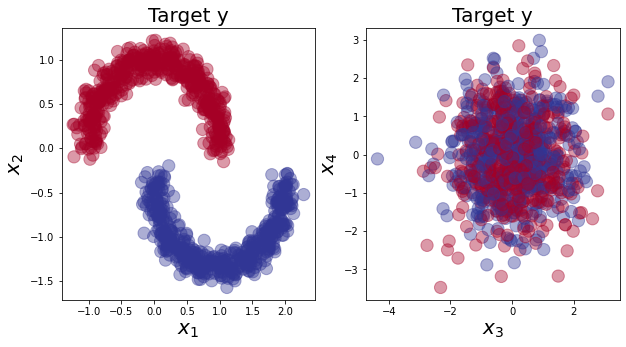

In [9]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        

ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[0].set_title('Target y',fontsize=20)
ax[1].scatter(x=X_data[:,2], y=X_data[:,3], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].set_xlabel('$x_3$',fontsize=20)
ax[1].set_ylabel('$x_4$',fontsize=20)
ax[1].set_title('Target y',fontsize=20)
plt.tick_params(labelsize=10)

## Filter Method

The ANOVA F-test is a filter method used for feature selection that evaluates the relationship between each feature and the target variable. 
By computing the F-statistic for each feature, this method selects the features that have the most significant statistical relationship with the target, helping to identify the most informative features.

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Feature selection using ANOVA F-test
f_selector = SelectKBest(f_classif, k=2)  # 'all' can be changed to the number of features you want
X_train_kbest = f_selector.fit_transform(X_train_scaled, y_train)
X_test_kbest = f_selector.transform(X_test_scaled)

# Train a logistic regression model
logistic_regression_model = LogisticRegression(penalty='none', solver='saga', max_iter=200, random_state=42)
logistic_regression_model.fit(X_train_kbest, y_train)

selected_features_bool = f_selector.get_support()
print("The Selected Features:",selected_features_bool)

# Make predictions and evaluate the model
y_pred = logistic_regression_model.predict(X_test_kbest)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

The Selected Features: [ True  True False False False False False False False False False False
 False False False False False False False False]
Accuracy: 1.0


## Wrapper Method

Recursive Feature Elimination (RFE) is a wrapper method for feature selection that recursively removes the least important features and builds the model on the remaining features. By iteratively fitting the model and pruning features, RFE helps to identify the most relevant features that contribute to the model's predictive performance.

In [6]:
logistic_reg = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
rfe_model = RFE(estimator=logistic_reg, n_features_to_select=2, step=1)
rfe_model.fit(X_train, y_train)
selected_features_bool = rfe_model.get_support()
print("The Selected Features:",selected_features_bool)
y_pred_rfe = rfe_model.predict(X_test)
rfe_acc=accuracy_score(y_test,y_pred_rfe)
print("accuracy:",rfe_acc)

The Selected Features: [ True  True False False False False False False False False False False
 False False False False False False False False]
accuracy: 1.0


## Embedded Method

LASSO (Least Absolute Shrinkage and Selection Operator) is an embedded method for feature selection that incorporates L1 regularization into the model training process. By adding a penalty proportional to the absolute values of the coefficients, LASSO shrinks some coefficients to zero, effectively performing feature selection during the model fitting process.

In [82]:
min_log = np.log10(0.005)
max_log = np.log10(20)
num_values = 20
reg_coeff_values = np.logspace(min_log, max_log, num=num_values)
select_features_list=[]
val_acc_list=[]
coeffs=[]
select_feature=0
test_acc_list=[]
for reg_coeff in reg_coeff_values: 
    # Create a Logistic Regression model with L1 penalty (Lasso) 
    model = LogisticRegression(penalty='l1', C=1/reg_coeff, solver='saga',max_iter=300, random_state=42)
    model.fit(X_train, y_train)
    select_feature=np.sum(model.coef_!= 0)
    select_features_list.append(select_feature)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    val_acc_list.append(accuracy)
    coeffs.append(model.coef_)

select_features_array = np.array(select_features_list)
coeffs_array = np.array(coeffs)
coeffs_flattened = coeffs_array.squeeze()


### Effect of Regularization on Feature Selection

In this examples, we demonstrate how the number of selected features changes as we vary the regularization coefficient. Increasing the value of the regularization coefficient increases the penalty, leading to more coefficients being driven to zero, and thus reducing the number of selected features.

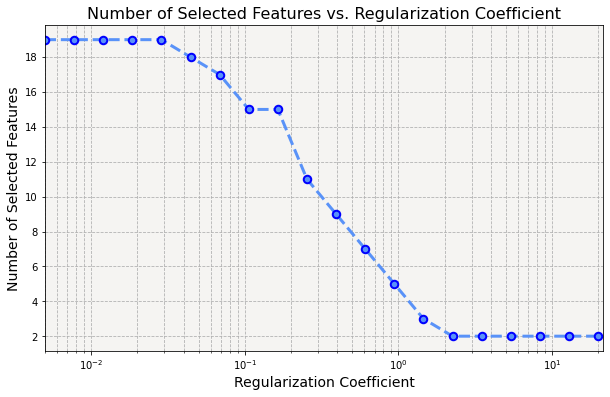

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(
    reg_coeff_values,
    select_features_array,
    "--o",
    color="#5992F8",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="b",
    markersize=7.5,
)
plt.xlabel("Regularization Coefficient",fontsize=14)
plt.ylabel("Number of Selected Features",fontsize=14)
plt.title("Number of Selected Features vs. Regularization Coefficient",fontsize=16)
plt.xscale("log")
plt.xlim(reg_coeff_values[0],reg_coeff_values[-1]+1.5)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid(True, which="both", ls="--")
plt.gca().set_facecolor('#F5F4F2')
plt.show()


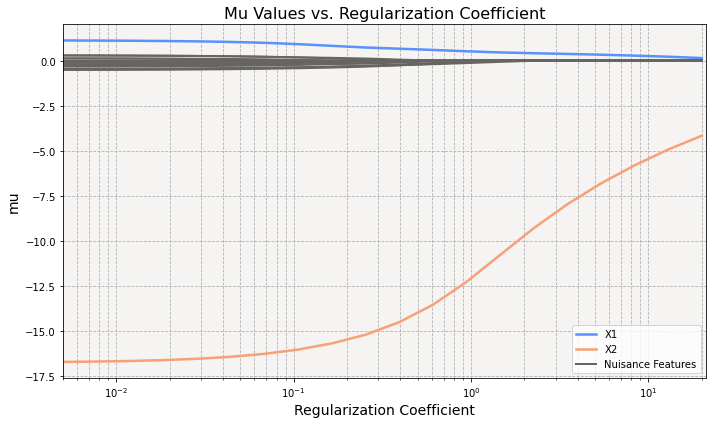

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(reg_coeff_values, coeffs_flattened[:, 0], label="X1", color="#5992F8", linewidth=2.5)
ax.plot(reg_coeff_values, coeffs_flattened[:, 1], label="X2", color="#F8A076", linewidth=2.5)

for i in range(2, coeffs_flattened.shape[1]):
    if i == 2:
        ax.plot(
            reg_coeff_values, coeffs_flattened[:, i], color="#666561", label="Nuisance Features"
       , linewidth=2)
    else:
        ax.plot(reg_coeff_values, coeffs_flattened[:, i], color="#666561", linewidth=2)

ax.set_title("Mu Values vs. Regularization Coefficient", fontsize=16)
ax.set_xlabel("Regularization Coefficient", fontsize=14)
ax.set_ylabel("mu", fontsize=14)
ax.set_xscale("log")
plt.xlim(reg_coeff_values[0], reg_coeff_values[-1] + 1)
plt.gca().set_facecolor("#F5F4F2")
ax.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
def clean_feature_selection_data(reg_coeff_values, select_features_list, test_acc_list):
    # Create a DataFrame from your lists
    data = {
        'Reg Coeff': reg_coeff_values,
        'Selected Features': select_features_list,
        'Test Accuracy': test_acc_list
    }
    df = pd.DataFrame(data)
    
    # Keep track of the last valid number of selected features
    last_valid = float('inf')

    # Iterate backwards and discard rows where the feature count increases
    for index, row in df.iterrows():
        if row['Selected Features'] <= last_valid:
            last_valid = row['Selected Features']
        else:
            df.drop(index, inplace=True)

    # Sort by regularization coefficient after cleaning
    df_sorted = df.sort_values(by=['Selected Features', 'Test Accuracy'], ascending=[True, False])
    df_unique = df_sorted.drop_duplicates(subset=['Selected Features'], keep='first')
    df_unique = df_unique.sort_values(by='Reg Coeff')
    unique_reg_coeff_values = df_unique['Reg Coeff'].tolist()
    unique_select_features_list = df_unique['Selected Features'].tolist()
    unique_test_acc_list = df_unique['Test Accuracy'].tolist()
    
    return unique_reg_coeff_values,unique_select_features_list,unique_test_acc_list


In [11]:
def experiment(x,y,min_features=2,max_log_coef=2,max_iter=300):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    min_log = np.log10(0.0001)
    max_log = np.log10(max_log_coef)
    num_values = round(x.shape[1]*1.5)
    reg_coeff_values = np.logspace(min_log, max_log, num=num_values)
    select_features_list=[]
    select_feature=0
    lasso_acc=[]
    for reg_coeff in reg_coeff_values:  
        # Create a Logistic Regression model with L1 penalty (Lasso) 
        model = LogisticRegression(penalty='l1', C=1/reg_coeff, solver='saga',max_iter=max_iter, random_state=42)
        model.fit(X_train, y_train)
        select_feature=np.sum(model.coef_!= 0)
        select_features_list.append(select_feature)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        lasso_acc.append(accuracy)
    
    select_features_lasso = np.array(select_features_list)

    anovaf_acc=[]
    rfe_acc=[]
    min_num_features=min(select_features_lasso)
    max_num_features=max(select_features_lasso)

    num_features_f_rfe = range(min_features,max_num_features)  # For Anova F test and RFE
    
    for i in num_features_f_rfe:
        f_selector = SelectKBest(f_classif, k=i)  # 'all' can be changed to the number of features you want
        X_train_kbest = f_selector.fit_transform(X_train_scaled, y_train)
        X_test_kbest = f_selector.transform(X_test_scaled)
        selected_features = f_selector.get_support(indices=True)
        logistic_regression_model = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
        logistic_regression_model.fit(X_train_kbest, y_train)
        y_pred_f = logistic_regression_model.predict(X_test_kbest)

        logistic_reg = LogisticRegression(penalty='none',solver='saga',max_iter=200,random_state=42)
        rfe_model = RFE(estimator=logistic_reg, n_features_to_select=i, step=1)
        rfe_model.fit(X_train, y_train)
        y_pred_rfe = rfe_model.predict(X_test)

        anovaf_acc.append(accuracy_score(y_test, y_pred_f))
        rfe_acc.append(accuracy_score(y_test, y_pred_rfe))

    return anovaf_acc,rfe_acc,lasso_acc,num_features_f_rfe,select_features_lasso

## Feature Selection Techniques Evaluation on Multiple Datasets

In this section, we evaluate the performance of the feature selection techniques described above on multiple datasets. We plot the test accuracy versus the number of selected features for each method on the following datasets:

- **Linear Two Moons**: This dataset consists of two interleaving half circles (moons) that have been adjusted to be linearly separable by increasing the distance between the moons.
- **Breast Cancer**: This dataset contains features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. It includes various attributes related to the cell nuclei present in the image.
- **Digits**: The digits dataset contains images of handwritten digits. Each image is represented by a feature vector of pixel values.
- **Non-linear Two Moons**: This is the original two moon dataset, which is inherently non-linearly separable, providing a challenging test case for feature selection methods.

Below, we plot the test accuracy versus the number of selected features for each feature selection method on these datasets.

In [7]:
# Synthetic Dataset- linear Two Moons
n_size = 1000 
p_size = 60   
X_moon_lin, y_moon_lin=create_twomoon_dataset(n_size,p_size)
X_moon_lin[y_moon_lin == 1, 1] -= 0.84 

# Breast Cancer Wisconsin Dataset
X_cancer, y_cancer = load_breast_cancer(return_X_y=True)

# Digits Dataset
X_digits, y_digits = load_digits(return_X_y=True)
binary_mask = (y_digits == 1) | (y_digits == 4)
X_digits = X_digits[binary_mask]
y_digits = y_digits[binary_mask]


# Synthetic Dataset- non-linear Two Moons  
X_moon, y_moon=create_twomoon_dataset(n_size,p_size)

datasets = {
    'Linear Two Moons': (X_moon_lin, y_moon_lin),
    'Breast Cancer': (X_cancer, y_cancer),
    'Digits': (X_digits, y_digits),
    'Non-Linear Two Moons':(X_moon,y_moon)
}


(1000,)
(1000, 60)
(1000,)
(1000, 60)


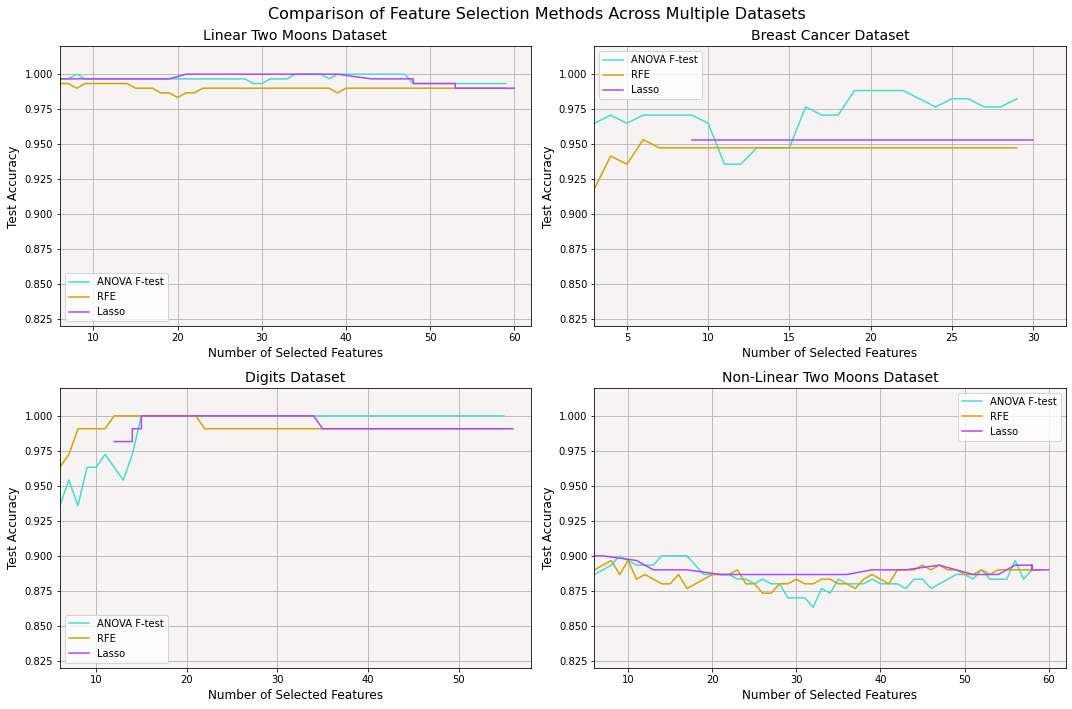

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, (X, y)) in enumerate(datasets.items()):
    f_acc, rfe_acc, lasso_acc, num_features_f_rfe, select_features_lasso = experiment(
        X, y, round(0.1 * X.shape[1]), 20, max_iter=500
    )

    axes[i].plot(
        num_features_f_rfe,
        f_acc,
        color="#47DBCD",
        label="ANOVA F-test",
        linewidth=1.5,
    )
    axes[i].plot(
        num_features_f_rfe,
        rfe_acc,
        color="#D6A104",
        label="RFE",
        linewidth=1.5,
    )
    axes[i].plot(
        select_features_lasso,
        lasso_acc,
        color="#AE46FA",
        label="Lasso",
        linewidth=1.5,
    )
    axes[i].set_facecolor('#F5F4F2')
    axes[i].set_title(f"{name} Dataset",fontsize=14)
    axes[i].set_xlabel("Number of Selected Features",fontsize=12)
    axes[i].set_ylabel("Test Accuracy",fontsize=12)
    axes[i].set_ylim(0.82, 1.02)
    axes[i].set_xlim(num_features_f_rfe[0],num_features_f_rfe[-1]+3)
    axes[i].legend()
    axes[i].grid(True)
fig.suptitle('Comparison of Feature Selection Methods Across Multiple Datasets', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Selection Using Stochastic Gates

As observed in the previous evaluations, the traditional feature selection methods struggled with the non-linear Two Moons dataset. These methods are often less effective in capturing the complex, non-linear relationships within the data, leading to suboptimal performance.

To address this limitation, we introduce the Stochastic Gates (STG) method, which is specifically designed to handle non-linear classification problems. The STG method incorporates a probabilistic approach to feature selection, allowing it to identify relevant features in complex, non-linear datasets effectively.

In [3]:
n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_twomoon_dataset(n_size,p_size,0.1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

(1000,)
(1000, 20)


In [4]:
feature_selection = True
model = featselectlib.STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.5, random_state=1, device='cpu') 

In [5]:
mu_prob,gates_prob=model.fit(X_train, y_train, nr_epochs=5000, valid_X=X_valid, valid_y=y_valid, print_interval=1000)

Epoch: 1000: loss=0.354451 valid_loss=0.249986
Epoch: 2000: loss=0.333592 valid_loss=0.248685
Epoch: 3000: loss=0.093586 valid_loss=0.028068
Epoch: 4000: loss=0.066455 valid_loss=0.005599
Epoch: 5000: loss=0.062881 valid_loss=0.004717


In [6]:
model.get_gates(mode='prob')

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [7]:
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


In this section, we describe the training process for the model incorporating Stochastic Gates (STG) for feature selection. During training, we monitor two key aspects of the gates: 

- **Mu Values** : These are the learned parameters that determine the activation probability of each gate.
- **Gate Probabilities** : These represent the probability of each gate being active at any given epoch.

By recording the evolution of these values over epochs, we gain insights into how the feature selection process progresses .



In [14]:
feature_selection = True
model = featselectlib.STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.5, random_state=42, device='cpu') 
mu_prob,gates_prob=model.fit(X_train, y_train, nr_epochs=500, valid_X=X_valid, valid_y=y_valid, print_interval=100)

Epoch: 100: loss=0.682092 valid_loss=0.193842
Epoch: 200: loss=0.582245 valid_loss=0.117460
Epoch: 300: loss=0.521281 valid_loss=0.107988
Epoch: 400: loss=0.466253 valid_loss=0.109149
Epoch: 500: loss=0.419704 valid_loss=0.112823


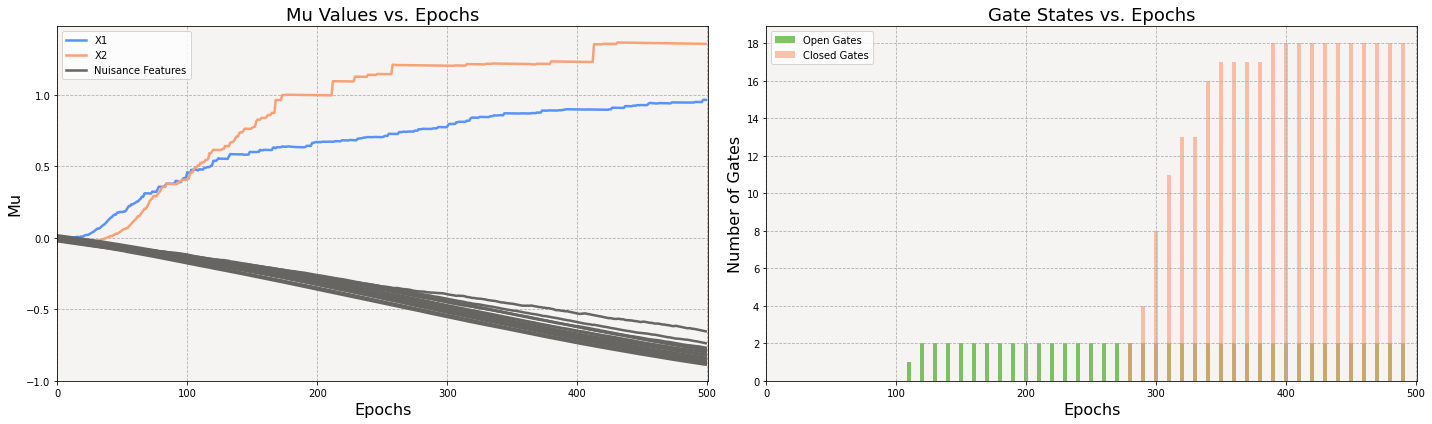

In [15]:
mu_array = np.array(mu_prob)
prob_array = np.array(gates_prob)
epochs = np.arange(mu_array.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

ax1.plot(epochs, mu_array[:, 0], label="X1", color="#5992F8", linewidth=2.5)
ax1.plot(epochs, mu_array[:, 1], label="X2", color="#F8A076", linewidth=2.5)


for i in range(2, mu_array.shape[1]):
    if i == 2:
        ax1.plot(epochs, mu_array[:, i], color="#666561",linewidth=2.5, label="Nuisance Features")
    else:
        ax1.plot(epochs, mu_array[:, i], color="#666561", linewidth=2.5)

ax1.set_title("Mu Values vs. Epochs", fontsize=18)
ax1.set_ylabel("Mu", fontsize=16)
ax1.set_xlabel("Epochs", fontsize=16)
ax1.grid(True, which="both", ls="--")
ax1.set_xlim(0,epochs[-1]+3)
ax1.set_facecolor('#F5F4F2')
ax1.legend()

step = 10
reduced_epochs = epochs[::step]
reduced_open_gates = np.sum(prob_array[::step] == 1, axis=1)
reduced_closed_gates = np.sum(prob_array[::step] == 0, axis=1)

open_gates = np.sum(prob_array == 1, axis=1)
closed_gates = np.sum(prob_array == 0, axis=1)


ax2.bar(reduced_epochs - 0.2, reduced_open_gates, width=3 ,alpha=0.6, color='#2D9E06', label='Open Gates')
ax2.bar(reduced_epochs + 0.2, reduced_closed_gates, width=3, alpha=0.6, color='#FC9875', label='Closed Gates')

ax2.set_title("Gate States vs. Epochs", fontsize=18)
ax2.set_xlabel("Epochs", fontsize=16)
ax2.set_ylabel("Number of Gates", fontsize=16)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.set_xlim(0,epochs[-1]+2)
ax2.set_facecolor('#F5F4F2')
ax2.grid(True, which="both", ls="--")
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
min_log = np.log10(0.05)
max_log = np.log10(0.5)
num_values = 40  

reg_coeff_values = np.logspace(min_log, max_log, num=num_values)
select_features_list=[]
test_acc_list=[]
gates_prob=[]
gates_mu=[]
feature_selection = True
select_feature=0
for reg_coeff in reg_coeff_values:
    model = STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
        optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=reg_coeff, random_state=1, device='cpu')
    print(f"Reg_coef= {reg_coeff:.4f}")
    model.fit(X_train, y_train, nr_epochs=5000, valid_X=X_valid, valid_y=y_valid, print_interval=5000)
    select_feature=sum(model.get_gates(mode='prob') > 0)
    y_pred=model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    select_features_list.append(select_feature)
    test_acc_list.append(accuracy)
    gates_mu.append(model.get_gates(mode='raw'))
    gates_prob.append(model.get_gates(mode='prob'))

Reg_coef= 0.0500
Epoch: 5000: loss=0.049632 valid_loss=0.757013
Reg_coef= 0.0530
Epoch: 5000: loss=0.052122 valid_loss=0.498066
Reg_coef= 0.0563
Epoch: 5000: loss=0.055494 valid_loss=0.596738
Reg_coef= 0.0597
Epoch: 5000: loss=0.059307 valid_loss=0.308679
Reg_coef= 0.0633
Epoch: 5000: loss=0.055382 valid_loss=0.193631
Reg_coef= 0.0672
Epoch: 5000: loss=0.064066 valid_loss=0.287085
Reg_coef= 0.0713
Epoch: 5000: loss=0.073687 valid_loss=0.755844
Reg_coef= 0.0756
Epoch: 5000: loss=0.060157 valid_loss=0.137402
Reg_coef= 0.0802
Epoch: 5000: loss=0.076627 valid_loss=0.655317
Reg_coef= 0.0851
Epoch: 5000: loss=0.044890 valid_loss=0.101817
Reg_coef= 0.0902
Epoch: 5000: loss=0.061318 valid_loss=0.066655
Reg_coef= 0.0957
Epoch: 5000: loss=0.057878 valid_loss=0.097581
Reg_coef= 0.1015
Epoch: 5000: loss=0.041339 valid_loss=0.031874
Reg_coef= 0.1077
Epoch: 5000: loss=0.089889 valid_loss=0.752450
Reg_coef= 0.1143
Epoch: 5000: loss=0.045104 valid_loss=0.037769
Reg_coef= 0.1212
Epoch: 5000: loss=0.050

To further understand the behavior of the Stochastic Gates method, we visualize two key aspects of the model with respect to the regularization coefficients:

1. **Number of Selected Features**: This plot shows how the number of selected features changes as the regularization coefficient varies,  how the model includes more or fewer features.
2. **Learning Probability Parameter**: This plot shows how the learning probability parameter for the gates changes with different regularization coefficients, illustrating the adjustment in feature importance as regularization strength varies.
3. **Gate States**: This plot illustrates the states of the gates (active or inactive) against the regularization coefficients, highlighting the selection or discarding of features at various levels of regularization.

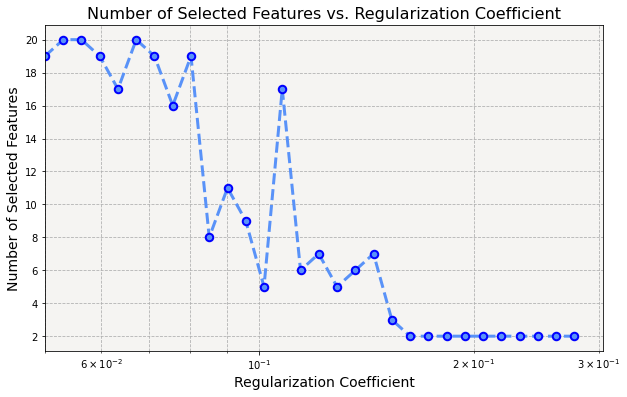

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(
    reg_coeff_values[0:-10],
    select_features_list[0:-10],
    "--o",
    color="#5992F8",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="b",
    markersize=7.5,
)
plt.xlabel("Regularization Coefficient", fontsize=14)
plt.ylabel("Number of Selected Features", fontsize=14)
plt.title("Number of Selected Features vs. Regularization Coefficient", fontsize=16)
plt.xscale("log")  # Since regularization coefficients can vary over orders of magnitude
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlim(reg_coeff_values[0],reg_coeff_values[-10]+0.01)
plt.gca().set_facecolor('#F5F4F2')
plt.grid(True, which="both", ls="--")
plt.show()

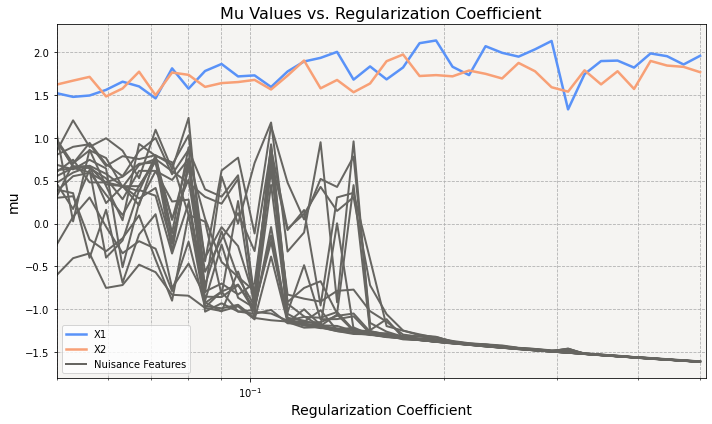

In [52]:
mu_array = np.array(gates_mu)
prob_array = np.array(gates_prob)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(reg_coeff_values, mu_array[:, 0], label="X1", color="#5992F8", linewidth=2.5)
ax.plot(reg_coeff_values, mu_array[:, 1], label="X2", color="#F8A076", linewidth=2.5)

for i in range(2, mu_array.shape[1]):
    if i == 2:
        ax.plot(
            reg_coeff_values, mu_array[:, i], color="#666561", label="Nuisance Features"
       , linewidth=2)
    else:
        ax.plot(reg_coeff_values, mu_array[:, i], color="#666561", linewidth=2)

ax.set_title("Mu Values vs. Regularization Coefficient", fontsize=16)
ax.set_xlabel("Regularization Coefficient", fontsize=14)
ax.set_ylabel("mu", fontsize=14)
ax.set_xscale("log")
plt.xlim(reg_coeff_values[0], reg_coeff_values[-1] + 0.01)
plt.gca().set_facecolor("#F5F4F2")
ax.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

To evaluate the performance of the STG method against other feature selection techniques, we compare the test accuracy versus the number of selected features for all four methods on the original  (non-linear) two moons dataset:

In [24]:
f_acc, rfe_acc, lasso_acc, num_features_f_rfe, select_features_lasso = experiment(X_data,y_data,2,30,max_iter=3000)

unique_reg_coeff_values, unique_select_features_list, unique_test_acc_list = clean_feature_selection_data(reg_coeff_values, select_features_list, test_acc_list)


<Figure size 432x288 with 0 Axes>

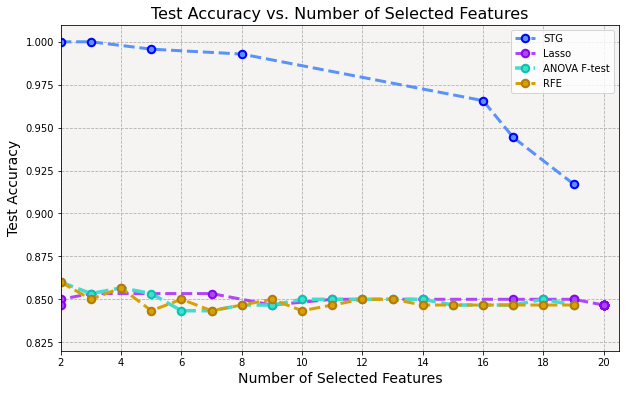

In [37]:
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(
    unique_select_features_list,
    unique_test_acc_list,
    "--o",
    color="#5992F8",
    label="STG",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="b",
    markersize=7.5, 
)
plt.plot(
    select_features_lasso,
    lasso_acc,
    "--o",
    color="#AE46FA",
    label="Lasso",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#8906E9",
    markersize=7.5, 
)
plt.plot(
    num_features_f_rfe,
    f_acc,
    "--o",
    color="#47DBCD",
    label="ANOVA F-test",
    linewidth=3.5,
    markeredgewidth=2,
    markeredgecolor="#03C3B1",
    markersize=7.5, 
)
plt.plot(
    num_features_f_rfe,
    rfe_acc,
    "--o",
    color="#D6A104",
    label="RFE",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#B47A04",
    markersize=7.5, 
)
plt.xlabel("Number of Selected Features", fontsize=14)
plt.ylabel("Test Accuracy", fontsize=14)
plt.title("Test Accuracy vs. Number of Selected Features", fontsize=16)
plt.grid(True, ls="--")
plt.ylim(0.82, 1.01)
plt.xlim(2,20.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().set_facecolor('#F5F4F2')
plt.legend()
plt.show()